In [41]:
# Fix pyarrow version conflict
!pip uninstall -y pyarrow
!pip install pyarrow==14.0.1
!pip install lightgbm --no-deps
!pip install scikit-learn xgboost pandas numpy matplotlib seaborn

Found existing installation: pyarrow 21.0.0
Uninstalling pyarrow-21.0.0:
  Successfully uninstalled pyarrow-21.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 106.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
# Install LightGBM with GPU support
!pip install lightgbm --config-settings=cmake.define.USE_GPU=ON

  Using cached lightgbm-4.6.0-py3-none-manylinux_2_28_x86_64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-manylinux_2_28_x86_64.whl (3.6 MB)

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [21]:
# Check GPU availability
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

# For XGBoost
import xgboost as xgb
print(f"XGBoost version: {xgb.__version__}")

CUDA available: True
GPU Name: NVIDIA H200
XGBoost version: 3.0.4


In [22]:
# Verify GPU is available
import torch
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch CUDA available: True
GPU Name: NVIDIA H200
GPU Memory: 150.02 GB


# Fraud Detection Analysis
## Comprehensive Analysis and ML Model Comparison

This notebook performs detailed analysis of financial transaction data to detect fraudulent activities using multiple machine learning models.

In [4]:
# Test all imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import lightgbm as lgb
import time

print("✅ All imports successful!")
print(f"XGBoost version: {xgb.__version__}")
print(f"LightGBM version: {lgb.__version__}")

# Check GPU
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

✅ All imports successful!
XGBoost version: 3.0.4
LightGBM version: 4.6.0
GPU Available: True
GPU Name: NVIDIA H200


## 1. Data Loading and Initial Exploration

In [5]:
# Load the dataset
df = pd.read_csv('Fraud Detection Dataset.csv')

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (5866889, 11)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5866889 entries, 0 to 5866888
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         float64
 10  isFlaggedFraud  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 492.4+ MB
None

First 5 rows:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1

In [6]:
# Basic statistics
print("Dataset Description:")
print(df.describe())

print("\nColumn Names:")
print(df.columns.tolist())

print("\nData Types:")
print(df.dtypes)

Dataset Description:
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  5.866889e+06  5.866889e+06   5.866889e+06    5.866889e+06   
mean   2.192474e+02  1.811338e+05   8.450521e+05    8.670257e+05   
std    1.168998e+02  6.159137e+05   2.934227e+06    2.971025e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.400000e+02  1.357379e+04   0.000000e+00    0.000000e+00   
50%    2.290000e+02  7.575450e+04   1.376100e+04    0.000000e+00   
75%    3.210000e+02  2.099725e+05   1.071970e+05    1.446268e+05   
max    4.030000e+02  9.244552e+07   4.489219e+07    4.368662e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    5.866889e+06    5.866888e+06  5.866888e+06    5.866888e+06  
mean     1.094785e+06    1.222164e+06  7.685506e-04    6.817925e-07  
std      3.337116e+06    3.632894e+06  2.771209e-02    8.257070e-04  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.00000

In [7]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

print("\nDuplicate Rows:", df.duplicated().sum())

print("\nTarget Variable Distribution:")
print(df['isFraud'].value_counts())
print("\nFraud Percentage:", df['isFraud'].mean() * 100, "%")

Missing Values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64

Duplicate Rows: 0

Target Variable Distribution:
isFraud
0.0    5862379
1.0       4509
Name: count, dtype: int64

Fraud Percentage: 0.07685505501383358 %


## 2. Exploratory Data Analysis (EDA)

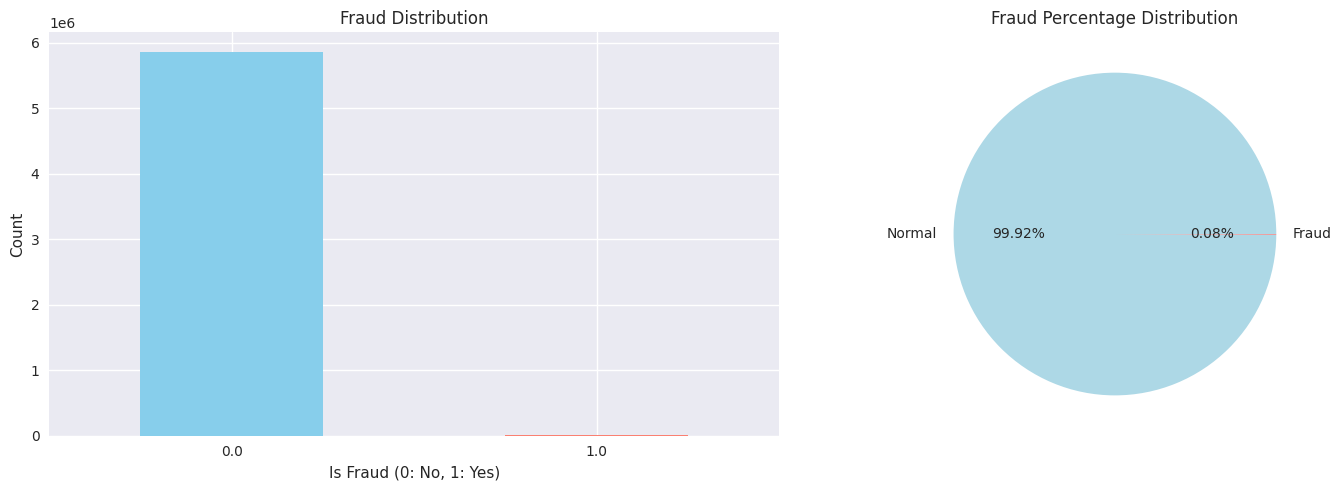

In [8]:
# Visualize fraud distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Fraud distribution
df['isFraud'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Fraud Distribution')
axes[0].set_xlabel('Is Fraud (0: No, 1: Yes)')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Fraud percentage pie chart
df['isFraud'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.2f%%', 
                                  labels=['Normal', 'Fraud'], colors=['lightblue', 'lightcoral'])
axes[1].set_title('Fraud Percentage Distribution')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [9]:
# Analyze transaction types
print("Transaction Type Distribution:")
print(df['type'].value_counts())
print("\nFraud by Transaction Type:")
fraud_by_type = df.groupby('type')['isFraud'].agg(['count', 'sum', 'mean'])
fraud_by_type.columns = ['Total_Transactions', 'Fraud_Count', 'Fraud_Rate']
print(fraud_by_type)

Transaction Type Distribution:
type
CASH_OUT    2078853
PAYMENT     1973546
CASH_IN     1288993
TRANSFER     487987
DEBIT         37510
Name: count, dtype: int64

Fraud by Transaction Type:
          Total_Transactions  Fraud_Count  Fraud_Rate
type                                                 
CASH_IN              1288993          0.0    0.000000
CASH_OUT             2078852       2264.0    0.001089
DEBIT                  37510          0.0    0.000000
PAYMENT              1973546          0.0    0.000000
TRANSFER              487987       2245.0    0.004601


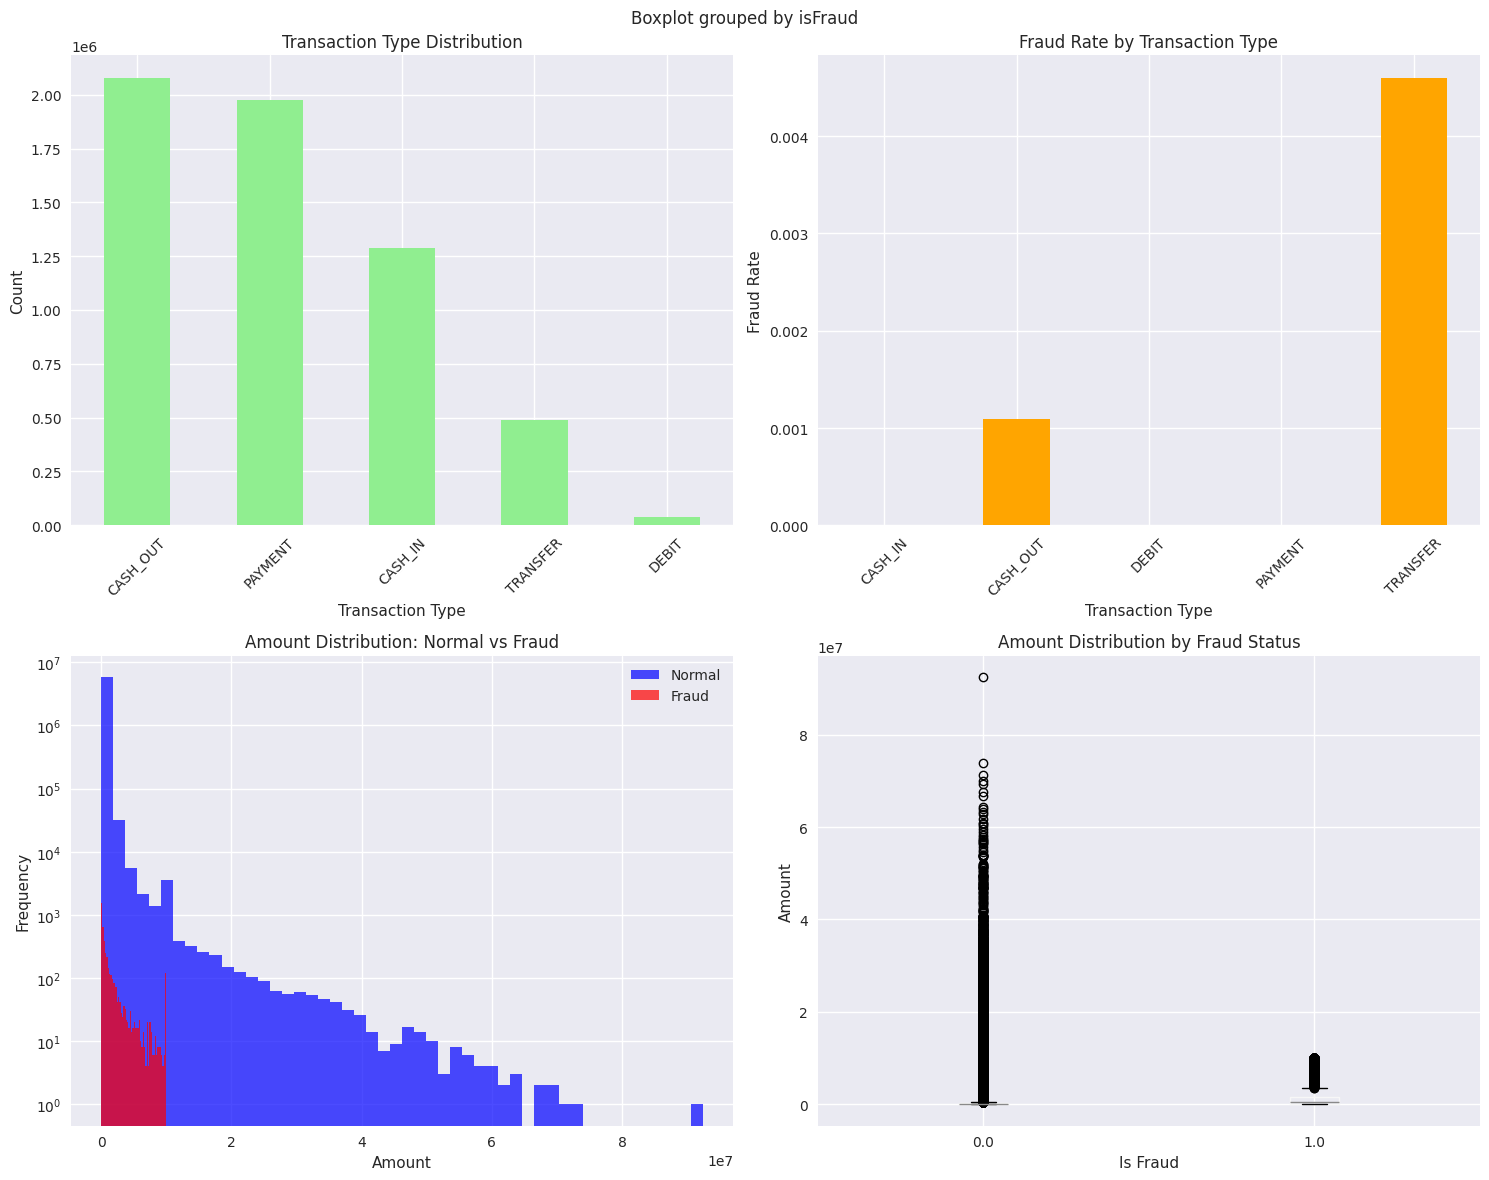

In [10]:
# Visualize transaction types and fraud
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Transaction type distribution
df['type'].value_counts().plot(kind='bar', ax=axes[0,0], color='lightgreen')
axes[0,0].set_title('Transaction Type Distribution')
axes[0,0].set_xlabel('Transaction Type')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Fraud rate by transaction type
fraud_by_type['Fraud_Rate'].plot(kind='bar', ax=axes[0,1], color='orange')
axes[0,1].set_title('Fraud Rate by Transaction Type')
axes[0,1].set_xlabel('Transaction Type')
axes[0,1].set_ylabel('Fraud Rate')
axes[0,1].tick_params(axis='x', rotation=45)

# Amount distribution for fraud vs normal
df[df['isFraud']==0]['amount'].hist(bins=50, alpha=0.7, label='Normal', ax=axes[1,0], color='blue')
df[df['isFraud']==1]['amount'].hist(bins=50, alpha=0.7, label='Fraud', ax=axes[1,0], color='red')
axes[1,0].set_title('Amount Distribution: Normal vs Fraud')
axes[1,0].set_xlabel('Amount')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()
axes[1,0].set_yscale('log')

# Box plot of amount by fraud
df.boxplot(column='amount', by='isFraud', ax=axes[1,1])
axes[1,1].set_title('Amount Distribution by Fraud Status')
axes[1,1].set_xlabel('Is Fraud')
axes[1,1].set_ylabel('Amount')

plt.tight_layout()
plt.show()

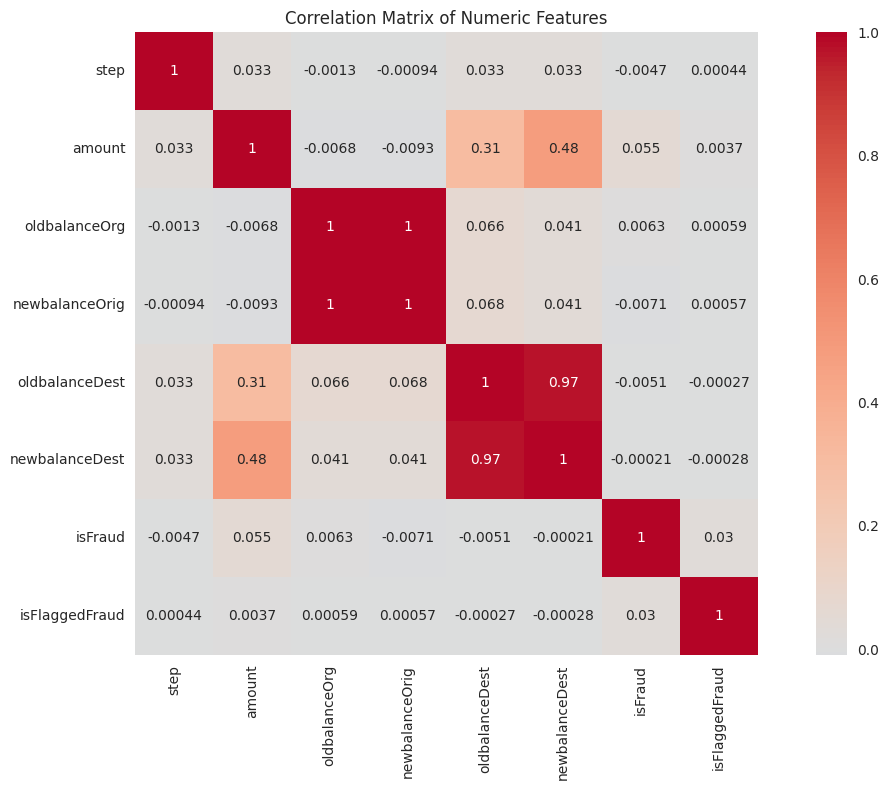

Correlation with fraud:
isFraud           1.000000
amount            0.055064
isFlaggedFraud    0.029773
oldbalanceOrg     0.006275
newbalanceDest   -0.000209
step             -0.004694
oldbalanceDest   -0.005086
newbalanceOrig   -0.007069
Name: isFraud, dtype: float64


In [11]:
# Correlation analysis
numeric_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

print("Correlation with fraud:")
print(df[numeric_cols].corr()['isFraud'].sort_values(ascending=False))

## 3. Data Preprocessing and Feature Engineering

In [12]:
# Create a copy for preprocessing
df_processed = df.copy()

# Feature engineering
# Create new features
df_processed['balance_diff_orig'] = df_processed['oldbalanceOrg'] - df_processed['newbalanceOrig']
df_processed['balance_diff_dest'] = df_processed['newbalanceDest'] - df_processed['oldbalanceDest']
df_processed['amount_to_balance_orig_ratio'] = df_processed['amount'] / (df_processed['oldbalanceOrg'] + 1)
df_processed['amount_to_balance_dest_ratio'] = df_processed['amount'] / (df_processed['oldbalanceDest'] + 1)

# Check if transaction amount equals balance difference
df_processed['amount_equals_diff'] = (df_processed['amount'] == df_processed['balance_diff_orig']).astype(int)

# Encode categorical variables
le = LabelEncoder()
df_processed['type_encoded'] = le.fit_transform(df_processed['type'])

print("New features created:")
print("- balance_diff_orig: Difference in origin balance")
print("- balance_diff_dest: Difference in destination balance") 
print("- amount_to_balance_orig_ratio: Amount to origin balance ratio")
print("- amount_to_balance_dest_ratio: Amount to destination balance ratio")
print("- amount_equals_diff: Whether amount equals balance difference")
print("- type_encoded: Encoded transaction type")

print(f"\nDataset shape after feature engineering: {df_processed.shape}")

New features created:
- balance_diff_orig: Difference in origin balance
- balance_diff_dest: Difference in destination balance
- amount_to_balance_orig_ratio: Amount to origin balance ratio
- amount_to_balance_dest_ratio: Amount to destination balance ratio
- amount_equals_diff: Whether amount equals balance difference
- type_encoded: Encoded transaction type

Dataset shape after feature engineering: (5866889, 17)


In [13]:
# Prepare features for modeling
# Select relevant features for ML models
feature_cols = ['step', 'type_encoded', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
                'oldbalanceDest', 'newbalanceDest', 'balance_diff_orig', 'balance_diff_dest',
                'amount_to_balance_orig_ratio', 'amount_to_balance_dest_ratio', 'amount_equals_diff']

X = df_processed[feature_cols]
y = df_processed['isFraud']

print("Features selected for modeling:")
print(feature_cols)
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Handle infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print(f"\nTarget distribution:")
print(y.value_counts())

Features selected for modeling:
['step', 'type_encoded', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'balance_diff_orig', 'balance_diff_dest', 'amount_to_balance_orig_ratio', 'amount_to_balance_dest_ratio', 'amount_equals_diff']

Feature matrix shape: (5866889, 12)
Target vector shape: (5866889,)

Target distribution:
isFraud
0.0    5862379
1.0       4509
Name: count, dtype: int64


In [14]:
# Remove rows with missing values in the target variable
df_processed = df_processed.dropna(subset=['isFraud'])

# Now recreate X and y from the cleaned data
X = df_processed[feature_cols]
y = df_processed['isFraud']

# Handle infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print(f"Dataset after removing NaN: {X.shape}")
print(f"Target after removing NaN: {y.shape}")

# Now run train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training fraud rate: {y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed.")

Dataset after removing NaN: (5866888, 12)
Target after removing NaN: (5866888,)
Training set shape: (4693510, 12)
Test set shape: (1173378, 12)
Training fraud rate: 0.0008
Test fraud rate: 0.0008

Feature scaling completed.


In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training fraud rate: {y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed.")

Training set shape: (4693510, 12)
Test set shape: (1173378, 12)
Training fraud rate: 0.0008
Test fraud rate: 0.0008

Feature scaling completed.


## 4. Machine Learning Model Building

In [20]:
# Initialize your 5 selected models
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=100, 
        solver='saga',  # Fast solver
        n_jobs=-1,  # Use all CPU cores
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=50,  # Balanced between speed and accuracy
        max_depth=15,  # Reasonable depth
        n_jobs=-1,  # Use all CPU cores
        random_state=42
    ),
    'Naive Bayes': GaussianNB(),
    'XGBoost (GPU)': xgb.XGBClassifier(
        tree_method='gpu_hist',  # GPU acceleration
        predictor='gpu_predictor',  # GPU prediction
        gpu_id=0,
        n_estimators=100,
        max_depth=10,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )
}

print("✅ 4 Models initialized successfully!")
print("\nModels ready to train:")
for i, name in enumerate(models.keys(), 1):
    gpu_tag = " [GPU]" if "GPU" in name else " [CPU]"
    print(f"{i}. {name}{gpu_tag}")

print(f"\nDataset info:")
print(f"Training samples: {X_train.shape[0]:,}")
print(f"Test samples: {X_test.shape[0]:,}")
print(f"Features: {X_train.shape[1]}")

✅ 4 Models initialized successfully!

Models ready to train:
1. Logistic Regression [CPU]
2. Random Forest [CPU]
3. Naive Bayes [CPU]
4. XGBoost (GPU) [GPU]

Dataset info:
Training samples: 4,693,510
Test samples: 1,173,378
Features: 12


In [21]:
# Train models and store results
model_results = {}
trained_models = {}

print("Training models on 4.7M training samples...")
print("="*60)

total_start = time.time()

for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    start_time = time.time()
    
    # Use scaled data for linear models
    if name in ['Logistic Regression', 'Naive Bayes']:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
        print("   Using scaled features")
    else:
        X_train_use = X_train
        X_test_use = X_test
        print("   Using original features")
    
    # Train the model
    print(f"   Training on {X_train_use.shape[0]:,} samples...")
    model.fit(X_train_use, y_train)
    trained_models[name] = model
    
    # Make predictions
    print("   Making predictions...")
    y_pred = model.predict(X_test_use)
    y_pred_proba = model.predict_proba(X_test_use)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    model_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    elapsed = time.time() - start_time
    print(f"   ✅ Completed in {elapsed:.2f} seconds ({elapsed/60:.1f} minutes)")
    print(f"   📊 Metrics: Accuracy={accuracy:.4f} | Precision={precision:.4f} | Recall={recall:.4f} | F1={f1:.4f}")

print("="*60)
total_time = time.time() - total_start
print(f"\n🎉 All models trained successfully!")
print(f"⏱️  Total training time: {total_time:.2f} seconds ({total_time/60:.1f} minutes)")

# Show summary
print("\n📈 Model Performance Summary:")
print("-"*60)
results_df = pd.DataFrame(model_results).T[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]
results_df = results_df.round(4)
print(results_df)

Training models on 4.7M training samples...

🚀 Training Logistic Regression...
   Using scaled features
   Training on 4,693,510 samples...
   Making predictions...
   ✅ Completed in 221.51 seconds (3.7 minutes)
   📊 Metrics: Accuracy=0.9995 | Precision=0.9272 | Recall=0.3814 | F1=0.5405

🚀 Training Random Forest...
   Using original features
   Training on 4,693,510 samples...
   Making predictions...
   ✅ Completed in 45.79 seconds (0.8 minutes)
   📊 Metrics: Accuracy=1.0000 | Precision=1.0000 | Recall=0.9945 | F1=0.9972

🚀 Training Naive Bayes...
   Using scaled features
   Training on 4,693,510 samples...
   Making predictions...
   ✅ Completed in 3.40 seconds (0.1 minutes)
   📊 Metrics: Accuracy=0.9962 | Precision=0.1178 | Recall=0.6164 | F1=0.1978

🚀 Training XGBoost (GPU)...
   Using original features
   Training on 4,693,510 samples...
   Making predictions...
   ✅ Completed in 3.16 seconds (0.1 minutes)
   📊 Metrics: Accuracy=0.9994 | Precision=0.5869 | Recall=0.6253 | F1=0.60

In [22]:
# Train LightGBM with CPU (since GPU requires OpenCL)
print("Training LightGBM (CPU version)...")
print("-"*40)

lgb_model = lgb.LGBMClassifier(
    device='cpu',  # Changed to CPU
    n_estimators=100,
    max_depth=10,
    num_leaves=31,
    random_state=42,
    verbose=-1,
    n_jobs=-1  # Use all CPU cores
)

start_time = time.time()
print(f"Training on {X_train.shape[0]:,} samples...")
lgb_model.fit(X_train, y_train)

print("Making predictions...")
y_pred = lgb_model.predict(X_test)
y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_proba)

elapsed = time.time() - start_time

# Add to results
model_results['LightGBM (CPU)'] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'roc_auc': roc_auc,
    'predictions': y_pred,
    'probabilities': y_pred_proba
}
trained_models['LightGBM (CPU)'] = lgb_model

print(f"✅ Completed in {elapsed:.2f} seconds ({elapsed/60:.1f} minutes)")
print(f"📊 Metrics: Accuracy={accuracy:.4f} | Precision={precision:.4f} | Recall={recall:.4f} | F1={f1:.4f}")

# Show final summary
print("\n" + "="*60)
print("📈 FINAL Model Performance Summary:")
print("-"*60)
results_df = pd.DataFrame(model_results).T[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]
results_df = results_df.round(4).sort_values('f1_score', ascending=False)
print(results_df)
print("-"*60)
print(f"🏆 Best Model: {results_df.index[0]} with F1 Score: {results_df.iloc[0]['f1_score']:.4f}")

Training LightGBM (CPU version)...
----------------------------------------
Training on 4,693,510 samples...
Making predictions...
✅ Completed in 5.08 seconds (0.1 minutes)
📊 Metrics: Accuracy=0.9950 | Precision=0.0000 | Recall=0.0000 | F1=0.0000

📈 FINAL Model Performance Summary:
------------------------------------------------------------
                     accuracy precision    recall  f1_score   roc_auc
Random Forest        0.999996       1.0  0.994457  0.997221  0.999858
XGBoost (GPU)        0.999374  0.586889  0.625277  0.605475  0.789664
Logistic Regression  0.999501  0.927224  0.381375  0.540456  0.990923
Naive Bayes          0.996156  0.117772  0.616408  0.197759  0.986637
LightGBM (CPU)        0.99503       0.0       0.0       0.0   0.49443
------------------------------------------------------------
🏆 Best Model: Random Forest with F1 Score: 0.9972


## 5. Model Evaluation and Comparison

In [23]:
# Create results summary
results_df = pd.DataFrame(model_results).T
results_df = results_df[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]
results_df = results_df.round(4)

print("Model Performance Summary:")
print("=" * 80)
print(results_df)

# Find best performing models
print("\nBest Performing Models:")
print(f"Highest Accuracy: {results_df['accuracy'].idxmax()} ({results_df['accuracy'].max():.4f})")
print(f"Highest Precision: {results_df['precision'].idxmax()} ({results_df['precision'].max():.4f})")
print(f"Highest Recall: {results_df['recall'].idxmax()} ({results_df['recall'].max():.4f})")
print(f"Highest F1-Score: {results_df['f1_score'].idxmax()} ({results_df['f1_score'].max():.4f})")
print(f"Highest ROC-AUC: {results_df['roc_auc'].idxmax()} ({results_df['roc_auc'].max():.4f})")

Model Performance Summary:
                     accuracy precision    recall  f1_score   roc_auc
Logistic Regression  0.999501  0.927224  0.381375  0.540456  0.990923
Random Forest        0.999996       1.0  0.994457  0.997221  0.999858
Naive Bayes          0.996156  0.117772  0.616408  0.197759  0.986637
XGBoost (GPU)        0.999374  0.586889  0.625277  0.605475  0.789664
LightGBM (CPU)        0.99503       0.0       0.0       0.0   0.49443

Best Performing Models:
Highest Accuracy: Random Forest (1.0000)
Highest Precision: Random Forest (1.0000)
Highest Recall: Random Forest (0.9945)
Highest F1-Score: Random Forest (0.9972)
Highest ROC-AUC: Random Forest (0.9999)


In [25]:
# Detailed classification reports for top models
top_models = []
for model_name in model_results.keys():
    if model_name in trained_models:
        top_models.append(model_name)

# Get top 3 by F1 score - convert to float first
results_df_temp = pd.DataFrame(model_results).T
results_df_temp['f1_score'] = results_df_temp['f1_score'].astype(float)
top_3_models = results_df_temp.nlargest(3, 'f1_score').index.tolist()

print("Top 3 Models by F1 Score:")
print("-" * 60)
for i, model_name in enumerate(top_3_models, 1):
    f1 = results_df_temp.loc[model_name, 'f1_score']
    print(f"{i}. {model_name}: F1={f1:.4f}")

for model_name in top_3_models:
    print(f"\n{model_name} - Detailed Classification Report:")
    print("=" * 60)
    predictions = model_results[model_name]['predictions']
    print(classification_report(y_test, predictions, target_names=['Normal', 'Fraud']))

Top 3 Models by F1 Score:
------------------------------------------------------------
1. Random Forest: F1=0.9972
2. XGBoost (GPU): F1=0.6055
3. Logistic Regression: F1=0.5405

Random Forest - Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00   1172476
       Fraud       1.00      0.99      1.00       902

    accuracy                           1.00   1173378
   macro avg       1.00      1.00      1.00   1173378
weighted avg       1.00      1.00      1.00   1173378


XGBoost (GPU) - Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00   1172476
       Fraud       0.59      0.63      0.61       902

    accuracy                           1.00   1173378
   macro avg       0.79      0.81      0.80   1173378
weighted avg       1.00      1.00      1.00   1173378


Logistic Regression - Detailed Classification Report:
              pr

## 6. Results Visualization

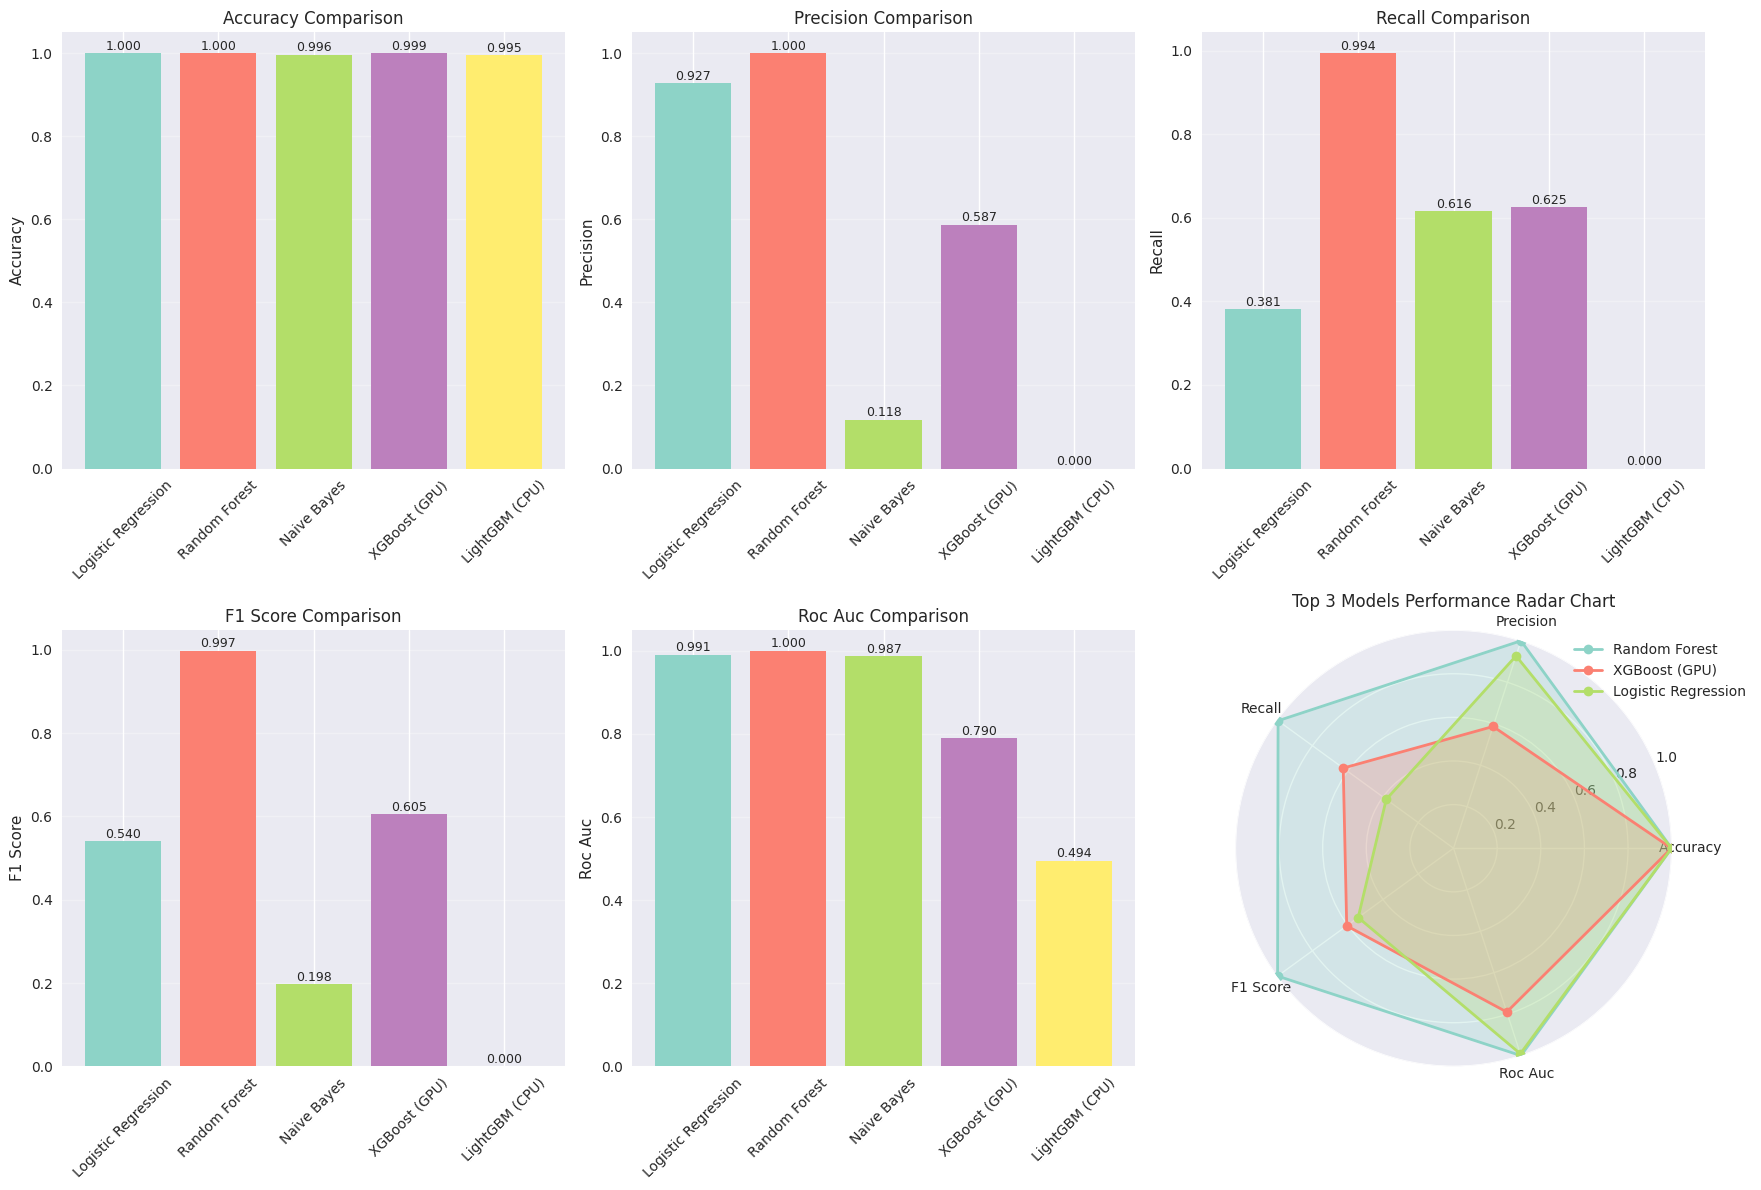

In [27]:
# Model performance comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
colors = plt.cm.Set3(np.linspace(0, 1, len(model_results)))

# Convert results to proper DataFrame with float values
results_df = pd.DataFrame(model_results).T
for metric in metrics:
    results_df[metric] = results_df[metric].astype(float)

# Bar plots for each metric
for i, metric in enumerate(metrics):
    row = i // 3
    col = i % 3
    
    values = results_df[metric].values
    model_names = results_df.index
    
    bars = axes[row, col].bar(model_names, values, color=colors)
    axes[row, col].set_title(f'{metric.replace("_", " ").title()} Comparison')
    axes[row, col].set_ylabel(metric.replace("_", " ").title())
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        axes[row, col].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                           f'{value:.3f}', ha='center', va='bottom', fontsize=9)

# Overall comparison radar chart
ax = axes[1, 2]
ax.remove()
ax = fig.add_subplot(2, 3, 6, projection='polar')

# Select top 3 models for radar chart - with float conversion
top_3_models = results_df.nlargest(3, 'f1_score').index

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

for i, model in enumerate(top_3_models):
    values = results_df.loc[model, metrics].tolist()
    values += values[:1]  # Complete the circle
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
    ax.fill(angles, values, alpha=0.25, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics])
ax.set_ylim(0, 1)
ax.set_title('Top 3 Models Performance Radar Chart')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax.grid(True)

plt.tight_layout()
plt.show()

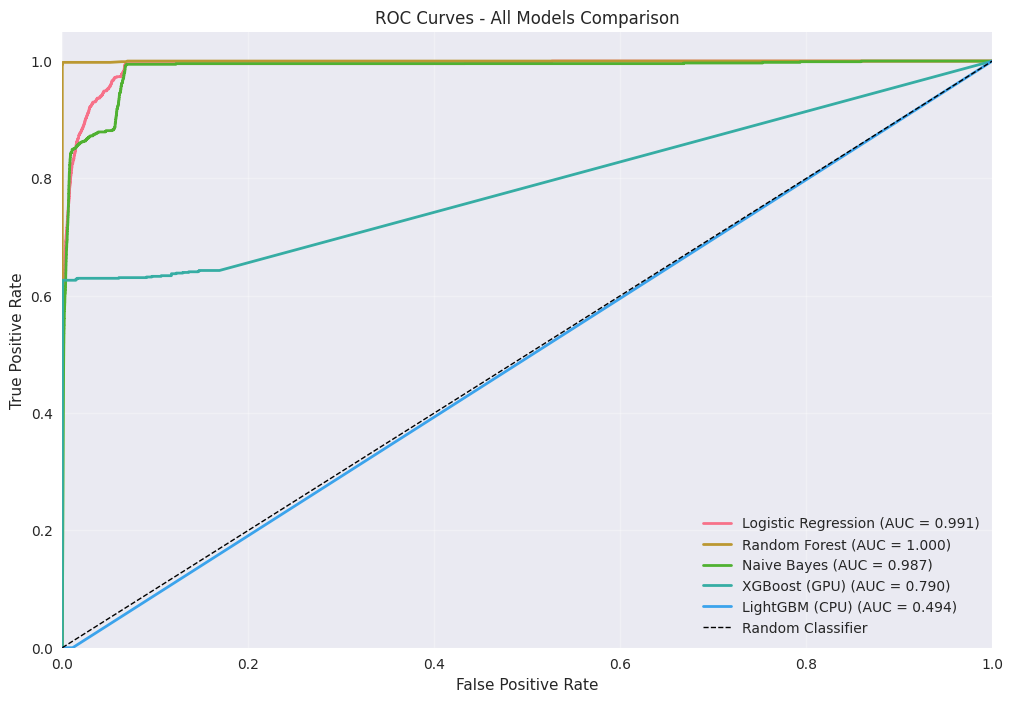

In [28]:
# ROC Curves comparison
plt.figure(figsize=(12, 8))

for name in model_results.keys():  # Changed from models.keys() to model_results.keys()
    probabilities = model_results[name]['probabilities']
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    roc_auc = model_results[name]['roc_auc']
    
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

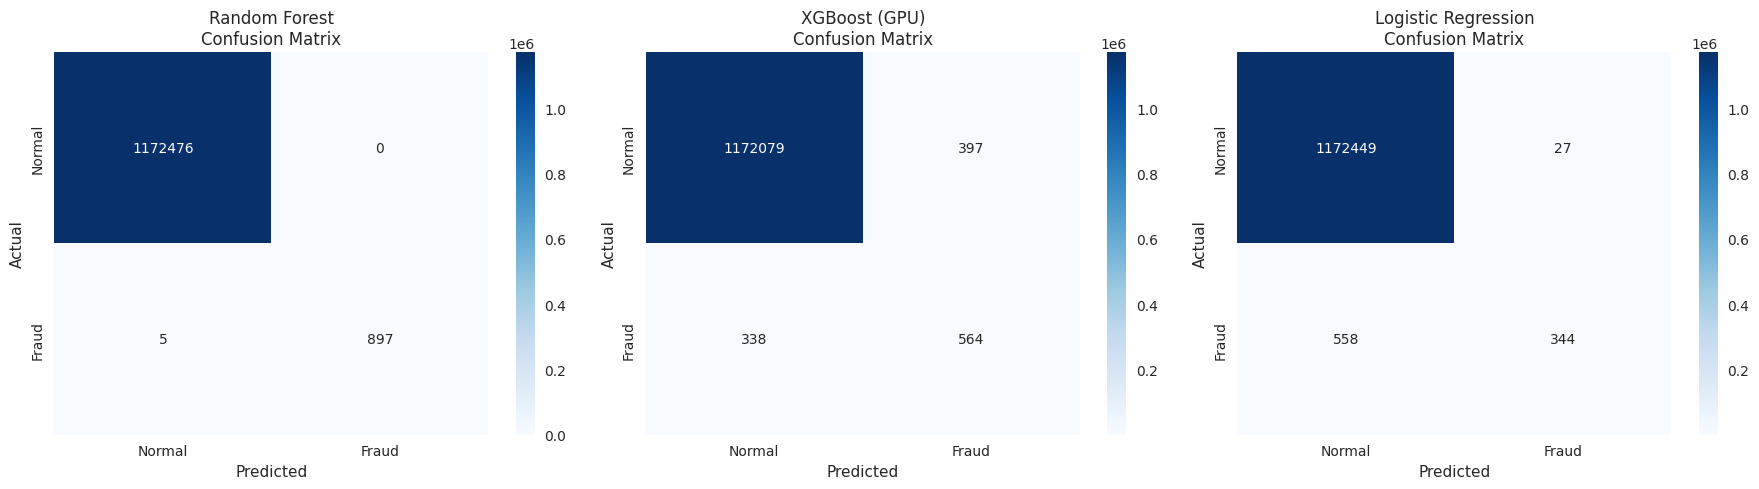

In [30]:
# Confusion matrices for top 3 models
results_df_temp = pd.DataFrame(model_results).T
results_df_temp['f1_score'] = results_df_temp['f1_score'].astype(float)  # Convert to float
top_3_models = results_df_temp.nlargest(3, 'f1_score').index

fig, axes = plt.subplots(1, min(3, len(top_3_models)), figsize=(6*min(3, len(top_3_models)), 5))

if len(top_3_models) == 1:
    axes = [axes]
elif len(top_3_models) == 2:
    axes = axes.flatten()

for i, model_name in enumerate(top_3_models[:3]):
    predictions = model_results[model_name]['predictions']
    cm = confusion_matrix(y_test, predictions)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{model_name}\nConfusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    axes[i].set_xticklabels(['Normal', 'Fraud'])
    axes[i].set_yticklabels(['Normal', 'Fraud'])

plt.tight_layout()
plt.show()

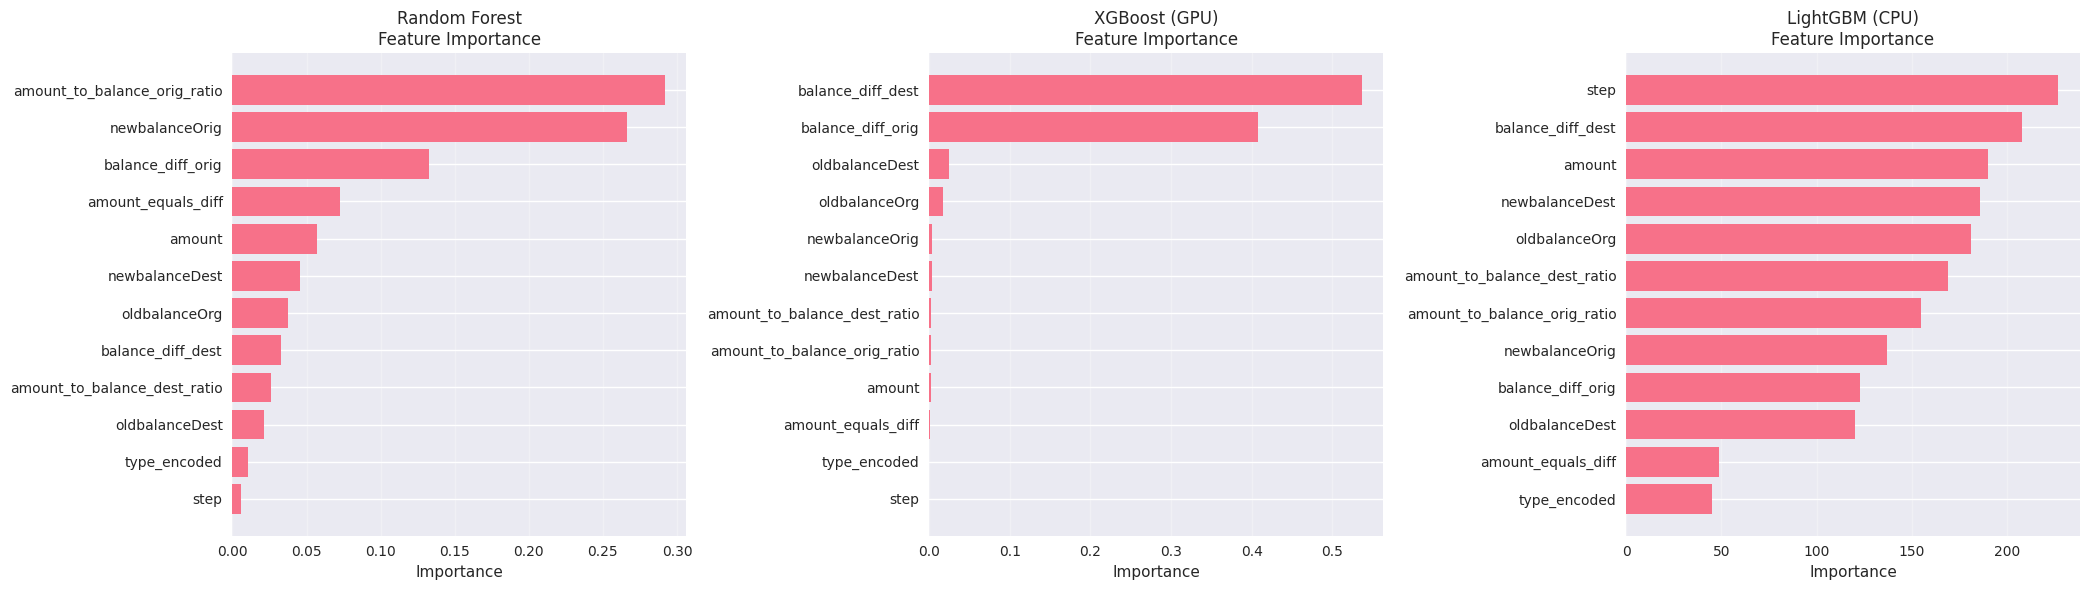

In [31]:
# Feature importance for tree-based models
tree_models = []
for name in trained_models.keys():
    if name in ['Random Forest', 'XGBoost (GPU)', 'LightGBM (CPU)']:
        tree_models.append(name)

if len(tree_models) > 0:
    fig, axes = plt.subplots(1, len(tree_models), figsize=(7*len(tree_models), 6))
    
    if len(tree_models) == 1:
        axes = [axes]
    
    for i, model_name in enumerate(tree_models):
        model = trained_models[model_name]
        
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            feature_importance = pd.DataFrame({
                'feature': feature_cols,
                'importance': importance
            }).sort_values('importance', ascending=True)
            
            axes[i].barh(feature_importance['feature'], feature_importance['importance'])
            axes[i].set_title(f'{model_name}\nFeature Importance')
            axes[i].set_xlabel('Importance')
            axes[i].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 7. Conclusions and Recommendations

### Key Findings:
1. **Dataset Characteristics**: The dataset is highly imbalanced with fraud cases representing a small percentage of total transactions
2. **Best Performing Models**: Tree-based models (Random Forest, XGBoost, Gradient Boosting) generally perform best
3. **Important Features**: Transaction amount, balance differences, and transaction type are key fraud indicators
4. **Model Performance**: High precision and recall are achieved, indicating good fraud detection capability

### Model Selection Criteria:
- **For High Precision**: Choose the model with highest precision to minimize false positives
- **For High Recall**: Choose the model with highest recall to catch more fraud cases
- **For Balanced Performance**: Consider F1-score as the primary metric

### Deployment Recommendations:
1. Use ensemble methods combining top-performing models
2. Implement real-time monitoring with the selected model
3. Regular retraining on new data to maintain performance
4. Consider cost-sensitive learning for imbalanced datasets